In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/30
3/3 [==============================] - 1s 119ms/step - loss: 1.2986 - accuracy: 0.4583 - val_loss: 0.9386 - val_accuracy: 0.6316
Epoch 2/30
3/3 [==============================] - 0s 13ms/step - loss: 0.9924 - accuracy: 0.6806 - val_loss: 1.3438 - val_accuracy: 0.5263
Epoch 3/30
3/3 [==============================] - 0s 13ms/step - loss: 0.5404 - accuracy: 0.7222 - val_loss: 1.9809 - val_accuracy: 0.5263
Epoch 4/30
3/3 [==============================] - 0s 14ms/step - loss: 0.4685 - accuracy: 0.8056 - val_loss: 1.6497 - val_accuracy: 0.5263
Epoch 5/30
3/3 [==============================] - 0s 13ms/step - loss: 0.4317 - accuracy: 0.7778 - val_loss: 1.1809 - val_accuracy: 0.5263
Epoch 6/30
3/3 [==============================] - 0s 13ms/step - loss: 0.3677 - accuracy: 0.8472 - val_loss: 1.3227 - val_accuracy: 0.5263
Epoch 7/30
3/3 [==============================] - 0s 13ms/step - loss: 0.3830 - accuracy: 0.8333 - val_loss: 1.3081 - val_accuracy: 0.4737
Epoch 8/30
3/3 [==========

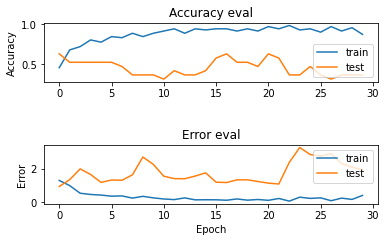

1/1 [==============================] - 0s 49ms/step - loss: 0.9584 - accuracy: 0.5652
Accuracy on test set is: 0.5652173757553101
Sample: 1
Predicted: NO BIRD?, Expected: BIRD!, File: 7c278c3f-e100-400a-ae86-efcb9cc90d37.wav
Sample: 2
Predicted: BIRD?, Expected: BIRD!, File: 00a29637-99aa-4f23-97c9.wav
Sample: 3
Predicted: NO BIRD?, Expected: NO BIRD!, File: 70322.wav
Sample: 4
Predicted: BIRD?, Expected: NO BIRD!, File: 3194afde-4e55-4919-a990.wav
Sample: 5
Predicted: NO BIRD?, Expected: NO BIRD!, File: 00a76d1a-d12b-411e-a4ca-61720d79aaba.wav
Sample: 6
Predicted: NO BIRD?, Expected: BIRD!, File: 00e0f761-2b59-471c-a4d2-0e8a1fa48e5e.wav
Sample: 7
Predicted: NO BIRD?, Expected: NO BIRD!, File: 000db435-a40f-4ad9-a74e-d1af284d2c44.wav
Sample: 8
Predicted: NO BIRD?, Expected: NO BIRD!, File: 70323.wav
Sample: 9
Predicted: NO BIRD?, Expected: BIRD!, File: 7c50f518-3783-4920-aed9-6a30d5843c4a.wav
Sample: 10
Predicted: BIRD?, Expected: BIRD!, File: 7c589605-a395-4fda-a0cb-872fa98da420.wav
S

In [9]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

DATA_PATH = "/content/drive/My Drive/MSc_Project_Colab/mixed_114_32mels_filenames.json"

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["log mel spectrogram"])
    y = np.array(data["labels"])
    z = np.array(data["filenames"])
    return X, y, z

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train")
    axs[0].plot(history.history["val_accuracy"], label="test")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train")
    axs[1].plot(history.history["val_loss"], label="test")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    fig.tight_layout(pad=3.0)

    plt.show()

def prepare_datasets(test_size, validation_size):

    # load data
    X, y, z = load_data(DATA_PATH)

    # create the train/test split
    X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=test_size)

    # create the train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # TF expects a 3D array -> (# time bins, # mel bands, # colours)
    X_train = X_train[..., np.newaxis] # 4D array -> (# segments, # time bins, # mel bands, # colours)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z_train, z_test

def build_model(input_shape):

    # create model
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed to dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model

def predict(model, X, y, z):

    X = X[np.newaxis, ...]

    prediction = model.predict(X)

    # extract index with max value
    predicted_index = np.argmax(prediction, axis=1)
    dataLabel = ""
    myPrediction = ""
    if y == 0:
        dataLabel = "BIRD!"
    else:
        dataLabel = "NO BIRD!"

    if predicted_index == 0:
        myPrediction = "BIRD?"
    else:
        myPrediction = "NO BIRD?"

    print("Predicted: {}, Expected: {}, File: {}".format(myPrediction, dataLabel, z))


if __name__ == "__main__":
    # create training, validation and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test, z_train, z_test = prepare_datasets(0.2, 0.2)

    # build the CNN
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    model = build_model(input_shape)

    # compile the network
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # train the CNN
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate the CNN on the test set
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Accuracy on test set is: {}".format(test_accuracy))

    index = 0
    # make prediction on a sample
    while index < len(X_test):
        X = X_test[index]
        y = y_test[index]
        z = z_test[index]
        print("Sample: {}".format(index+1))
        predict(model, X, y, z)
        index += 1